##### Libraries

In [30]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### Import and Filter

In [31]:
faa_id = 'LGA'

# Load the FAA UAS Facility Map Data
df = pd.read_csv('./FAA_UAS_FacilityMap_Data.csv')
# Filter the data to only include the EWR airport
df = df[df['APT1_FAAID'] == faa_id]
df = df[['CEILING', 'LATITUDE', 'LONGITUDE']]
print(df.shape)
# Faz a ordenação dos dados com base em LATITUDE e LONGITUDE
df = df.sort_values(["LATITUDE", "LONGITUDE"], ascending=[True, True])
df.reset_index(drop=True, inplace=True)
print(df)
duplicates = df[df.duplicated(['LATITUDE','LONGITUDE'], keep=False)]
print(f'Lat / Long duplicados: {duplicates}')

C:\Users\TEMP\AppData\Local\Temp\ipykernel_28884\1076018778.py:4: DtypeWarning: Columns (17,18,19,32,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./FAA_UAS_FacilityMap_Data.csv')


(1210, 3)
      CEILING   LATITUDE  LONGITUDE
0         400  40.554173 -73.912506
1         400  40.554173 -73.904173
2         400  40.554173 -73.895839
3         400  40.554173 -73.887506
4         400  40.562507 -73.920839
...       ...        ...        ...
1205      400  40.879173 -73.812506
1206      400  40.887507 -73.879173
1207      400  40.887507 -73.870839
1208      400  40.887507 -73.862506
1209      400  40.887507 -73.854173

[1210 rows x 3 columns]
Lat / Long duplicados: Empty DataFrame
Columns: [CEILING, LATITUDE, LONGITUDE]
Index: []


#### Convert Lat Long to Pixels

In [32]:
# Calculate boundaries
min_lat = df['LATITUDE'].min()
max_lat = df['LATITUDE'].max()
min_long = df['LONGITUDE'].min()
max_long = df['LONGITUDE'].max()
max_alt = df['CEILING'].max()
min_alt = df['CEILING'].min()

# Conversion parameters
base_cell_pixel = 70
pixel_por_grau = base_cell_pixel * 60

# Uma constante aproximada: quantos pés correspondem a 1 grau de latitude
pes_por_grau_latitude = 364000  # aproximadamente 111 km

# Calcular pixel por pé
pixel_por_pe = pixel_por_grau / pes_por_grau_latitude

# Convert coordinates to pixels
df['PIXEL_X'] = (df['LONGITUDE'] - min_long) * pixel_por_grau
df['PIXEL_Y'] = (max_lat - df['LATITUDE']) * pixel_por_grau
df['PIXEL_ALT'] = df['CEILING'] * pixel_por_pe  # Altitude em pixels, proporcional à escala de lat/long
df = df.drop(['LATITUDE', 'LONGITUDE', 'CEILING'], axis=1)
print(df)

         PIXEL_X      PIXEL_Y  PIXEL_ALT
0     350.000070  1400.000280   4.615385
1     385.000098  1400.000280   4.615385
2     420.000084  1400.000280   4.615385
3     455.000112  1400.000280   4.615385
4     315.000084  1365.000294   4.615385
...          ...          ...        ...
1205  770.000154    35.000028   4.615385
1206  490.000098     0.000000   4.615385
1207  525.000126     0.000000   4.615385
1208  560.000112     0.000000   4.615385
1209  595.000140     0.000000   4.615385

[1210 rows x 3 columns]


##### Create a CSV File of the filtered df

In [33]:
# Create a CSV file of the filtered dataframe
df.to_csv(f'./pixelized_data_{faa_id}.csv', index=False)

##### Plot the points

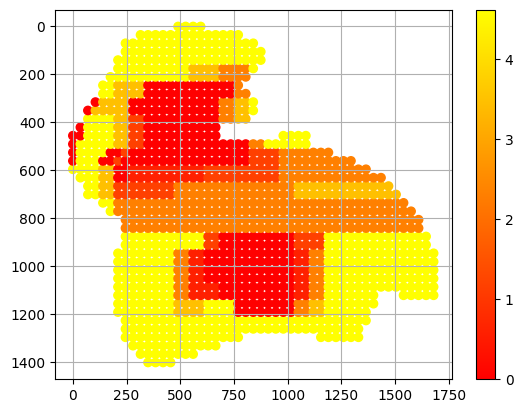

In [34]:
# Plot the data on a map
plt.scatter(df['PIXEL_X'], df['PIXEL_Y'], c=df['PIXEL_ALT'], cmap='autumn') 
plt.colorbar() # Add a colorbar
plt.grid(which='both') # Add a grid
plt.gca().invert_yaxis() # Invert the y-axis
plt.show() # Show the plot

#### Plot the grid map

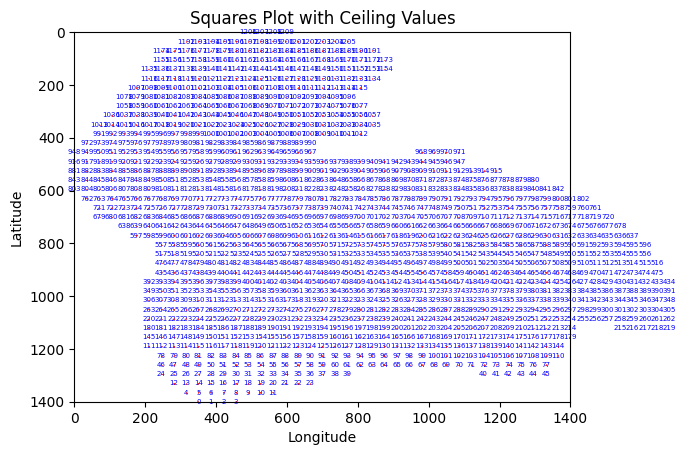

In [35]:
# Plot the squares
fig, ax = plt.subplots()
# Disable the default grid
ax.grid(False)
for index, row in df.iterrows():    
    # Use LONGITUDE and LATITUDE as the center of the square
    center_x = row['PIXEL_X']
    center_y = row['PIXEL_Y']
    
    # Calculate the bottom left corner based on the center
    bottom_left_x = center_x - 0.008
    bottom_left_y = center_y - 0.008
    
    # Create a rectangle patch for the square
    #square = plt.Rectangle((bottom_left_x, bottom_left_y), 0.016, 0.016, edgecolor='r', facecolor='none', linewidth=0.5)
    
    # Create a horizontal line
    horizontal_line = plt.Line2D([bottom_left_x-1, bottom_left_x + 1], [center_y, center_y], color='r', linewidth=0.5)
    ax.add_line(horizontal_line)
    
    # Create a vertical line
    vertical_line = plt.Line2D([center_x, center_x], [bottom_left_y-1, bottom_left_y + 1], color='r', linewidth=0.5)
    ax.add_line(vertical_line)
    
    #ax.add_patch(square)
    
    # Plot the ceiling value at the center of the square (using LONGITUDE and LATITUDE directly)
    ax.text(center_x+0.004, center_y+0.004, str(str(index)), color='blue', ha='center', va='center', fontsize=5, zorder=1)

# Set the limits of the plot (adjust padding as needed)
ax.set_xlim(df['PIXEL_X'].min() - 0.01, df['PIXEL_Y'].max() + 0.01)
ax.set_ylim(df['PIXEL_X'].min(), df['PIXEL_Y'].max() + 0.01)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().invert_yaxis() # Invert the y-axis
plt.title('Squares Plot with Ceiling Values')
plt.show()